<span style="font-size: 70px;"> Network: El Niño
    
    
<span style="font-size: 40px;">Eastern pacific vs world

In [1]:
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import jupyterlab_codex
import numpy as np
import timeit
import matplotlib as mpl
import cartopy.feature as cfeature
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib.cm as cm
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import glob
import matplotlib.colors as colors
import intake
import dask
from scipy.spatial import cKDTree
import networkx as nx
import psyplot.project as psy
import pandas as pd
from scipy.stats import pearsonr
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import warnings
from statsmodels.tsa.stattools import grangercausalitytests
import scipy.stats
from scipy import stats

dask.config.set({"array.slicing.split_large_chunks": True}) 

<span style="font-size: 40px;"> NOAA SST
    
    
https://psl.noaa.gov/data/gridded/data.cobe.html
1.0° latitude x 1.0° longitude global grid (360x180)

In [3]:
ds=xr.open_dataset('noaa_sst_mon_mean_updated.nc')

In [4]:
ds

<xarray.Dataset>
Dimensions:  (time: 1590, lon: 360, lat: 180)
Coordinates:
  * time     (time) datetime64[ns] 1891-01-01 1891-02-01 ... 2023-06-01
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    CDI:              Climate Data Interface version 2.3.0 (https://mpimet.mp...
    Conventions:      CF-1.2
    institution:      NOAA ESRL/PSD
    title:            COBE Sea Surface Temperature Analysis
    history:          Mon Jan 22 16:32:27 2024: cdo sellonlatbox,-180,180,-90...
    platform:         Analyses
    original_source:  http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_cat...
    comment:          recent values (w/i last year) may change as dataset is ...
    dataset_title:    COBE Sea Surface Temperature
    References:       https://www.psl.noaa.gov/data/gridded/data.cobe.html
    CDO:              Climate Data Operators version 2.3.0 (https://mpimet.mp...

In [5]:
ds=ds.sel(time=slice('2013-01-01T23:59:00.000000000', '2016-01-01T23:59:00.000000000'))

In [6]:
step=5

#find time that correspond to each other because atm2 starts from 2008-01-01

to=ds['sst'][:,::step,::step] 

In [7]:
to

<xarray.DataArray 'sst' (time: 36, lat: 36, lon: 72)>
[93312 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2013-02-01 2013-03-01 ... 2016-01-01
  * lon      (lon) float32 -179.5 -174.5 -169.5 -164.5 ... 165.5 170.5 175.5
  * lat      (lat) float32 89.5 84.5 79.5 74.5 69.5 ... -70.5 -75.5 -80.5 -85.5
Attributes:
    long_name:     Monthly Means of Global Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    dataset:       COBE Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual obs
    actual_range:  [-1.7999996 34.87     ]

In [8]:
to_monthly=to.values  #they are already monthly means

<span style="font-size: 50px;"> deseasonalise and normalise

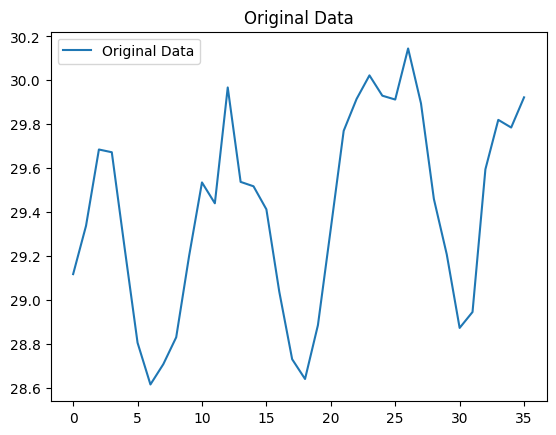

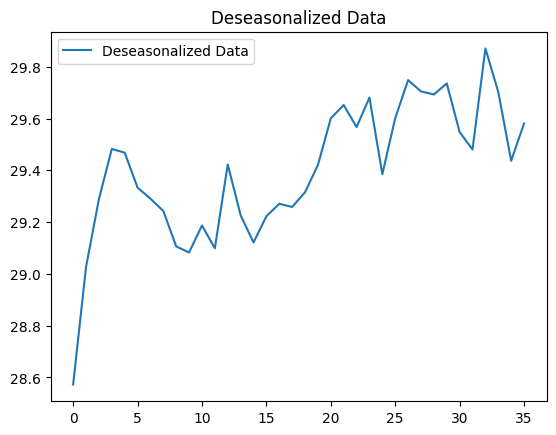

In [9]:
#SST

var_season=to_monthly
# Step 1: Plot the original data for one location (assuming one location for simplicity)
location_to_plot = (20, 3)  # latitude and longitude to plot (13,1) corresponds to 40N13E, near sardinia
plt.plot(var_season[:, location_to_plot[0], location_to_plot[1]], label='Original Data')
plt.title("Original Data")
plt.legend()
plt.show()

from statsmodels.tsa.seasonal import seasonal_decompose

# Create an empty array to store deseasonalized data
deseason_temp_sst = np.empty_like(var_season)

for lat in range(var_season.shape[1]):
    for lon in range(var_season.shape[2]):
        if np.all(~np.isnan(var_season[:, lat, lon])):
            decomposition = seasonal_decompose(var_season[:, lat, lon], model='additive', period=12)
            deseason_temp_sst[:, lat, lon] = var_season[:, lat, lon] - decomposition.seasonal
        else:
            # If there are NaN values, keep them in the deseasonalized array
            deseason_temp_sst[:, lat, lon] = var_season[:, lat, lon]

# Step 3: Plot the deseasonalized data for one location (assuming one location for simplicity)
plt.plot(deseason_temp_sst[:, location_to_plot[0], location_to_plot[1]], label='Deseasonalized Data')
plt.title("Deseasonalized Data")
plt.legend()
plt.show()



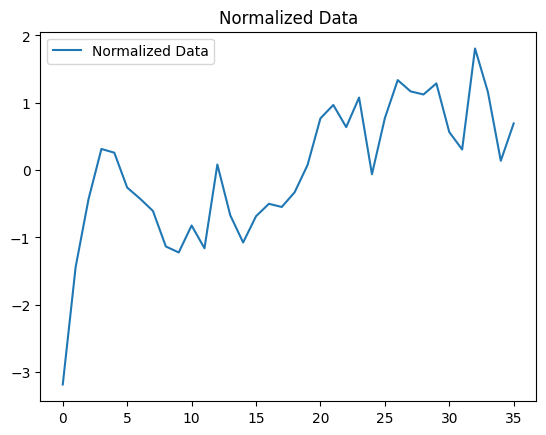

In [10]:
#SST

# Step 1: Calculate the long-term mean and standard deviation for each month
monthly_means = np.mean(deseason_temp_sst, axis=0)
monthly_stddevs = np.std(deseason_temp_sst, axis=0)

# Step 2: Normalize the data
normalized_data_sst = (deseason_temp_sst - monthly_means) / monthly_stddevs

# Now 'normalized_data' contains the normalized values for each data point
location_to_plot = (20, 3)  # latitude and longitude to plot (13,1) corresponds to 40N13E, near sardinia

# Step 6: Plot the normalized data for one location (assuming one location for simplicity)
plt.plot(normalized_data_sst[:, location_to_plot[0], location_to_plot[1]], label='Normalized Data')
plt.title("Normalized Data")
plt.legend()
plt.show()

<font size=20> Define functions

In [11]:
from math import radians, sin, cos, sqrt, atan2
#DISTANCE IN KM

def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Radius of the Earth in kilometers (mean value)
    radius = 6371.0

    # Calculate the distance
    distance = radius * c

    return distance


In [12]:
from concurrent.futures import ProcessPoolExecutor
n_cpu = 48 #48 is optimal
#max number of CPUs I can use is the number of latitudes we have

<font size=10> PEARSON: Eastern pacific vs world: With distance threshold

## Define area of El Nino

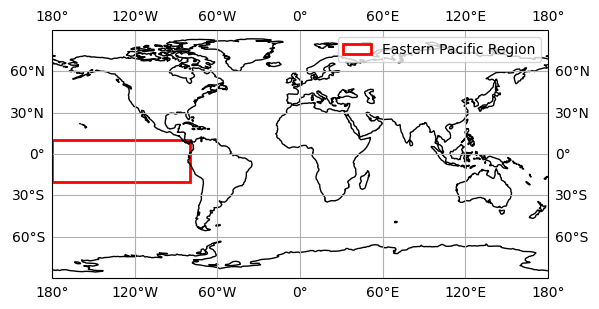

In [21]:

# Define the latitude and longitude bounds for the Eastern Pacific region
eastern_pacific_lat_bounds = (-20, 10)
eastern_pacific_lon_bounds = (-180, -79.5)

# Extract data for the Eastern Pacific region
eastern_pacific_region = ds.sel(
    lat=slice(eastern_pacific_lat_bounds[0], eastern_pacific_lat_bounds[1]),
    lon=slice(eastern_pacific_lon_bounds[0], eastern_pacific_lon_bounds[1])
)

# Plot the Eastern Pacific region
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot the selected region
ax.add_patch(plt.Rectangle(
    (eastern_pacific_lon_bounds[0], eastern_pacific_lat_bounds[0]),
    eastern_pacific_lon_bounds[1] - eastern_pacific_lon_bounds[0],
    eastern_pacific_lat_bounds[1] - eastern_pacific_lat_bounds[0],
    transform=ccrs.PlateCarree(),
    facecolor='none',
    edgecolor='red',
    linewidth=2,
    label='Eastern Pacific Region'
))

plt.legend()
plt.show()


# Create Network
## and save time series

In [13]:
#first element of the nodes is latitude, second is longitude



# Assuming you have your dataset loaded in 'ds' and 'step' defined
# Also, assuming 'normalized_data_sst' and 'normalized_data_tas' are your downsized and normalized data arrays
eke_downsized = normalized_data_sst
frshflux_downsized = normalized_data_sst

# Get the dimensions of the downsized arrays
num_time_steps, num_latitudes, num_longitudes = eke_downsized.shape
correlation_threshold = 0.9

# Define the latitude and longitude bounds for the Eastern Pacific region
eastern_pacific_lat_bounds = (-20, 10)
eastern_pacific_lon_bounds = (-180, -79.5)  # Adjust the longitude bounds as needed

# Function to check if a latitude and longitude are within the Eastern Pacific region
def is_in_eastern_pacific(lat, lon):
    return (eastern_pacific_lat_bounds[0] <= lat <= eastern_pacific_lat_bounds[1] and
            eastern_pacific_lon_bounds[0] <= lon <= eastern_pacific_lon_bounds[1])

# Define a function for parallelizing the computation of correlation
def correlation_parallel_func(lat_lon):
    lat, lon = lat_lon
    S = nx.Graph()

    # Check if the latitude and longitude are within the Eastern Pacific region
    if is_in_eastern_pacific(ds.lat.values[::step][lat], ds.lon.values[::step][lon]):
        # Extract time series at the current position in the Eastern Pacific
        time_series_eastern_pacific = eke_downsized[:, lat, lon]

        # Iterate over all positions (lat, lon) for the rest of the world
        for lat_rest_of_world in range(num_latitudes):
            for lon_rest_of_world in range(num_longitudes):
                # Skip positions within the Eastern Pacific
                if is_in_eastern_pacific(ds.lat.values[::step][lat_rest_of_world], ds.lon.values[::step][lon_rest_of_world]):
                    continue

                # Extract time series at the current position in the rest of the world
                time_series_rest_of_world = frshflux_downsized[:, lat_rest_of_world, lon_rest_of_world]

                # Check for NaN values
                if not (np.any(np.isnan(time_series_eastern_pacific)) or np.any(np.isnan(time_series_rest_of_world))):
                    # Calculate Pearson correlation coefficient
                    correlation = np.nan  # Default to NaN

                    if not np.all(time_series_eastern_pacific == time_series_eastern_pacific[0]) and not np.all(time_series_rest_of_world == time_series_rest_of_world[0]):
                        correlation, _ = pearsonr(time_series_eastern_pacific, time_series_rest_of_world)

                    # Check if correlation is above the threshold and nodes are far enough apart
                    if abs(correlation) > correlation_threshold:
                        distance_km = haversine_distance(
                            ds.lat.values[::step][lat], ds.lon.values[::step][lon],
                            ds.lat.values[::step][lat_rest_of_world], ds.lon.values[::step][lon_rest_of_world]
                        )

                        # Check if nodes are at least 20 km apart
                        if distance_km >= 5000:
                            # Add nodes to the graph with proper categorization
                            node_category_eastern_pacific = 'eastern_pacific'
                            node_eastern_pacific = (ds.lat.values[::step][lat], ds.lon.values[::step][lon], node_category_eastern_pacific)

                            node_category_rest_of_world = 'rest_of_the_world'
                            node_rest_of_world = (ds.lat.values[::step][lat_rest_of_world], ds.lon.values[::step][lon_rest_of_world], node_category_rest_of_world)

                            S.add_node(node_eastern_pacific, time_series=time_series_eastern_pacific)
                            S.add_node(node_rest_of_world, time_series=time_series_rest_of_world)

                            # Add weighted edge with correlation coefficient as weight
                            S.add_weighted_edges_from([(node_eastern_pacific, node_rest_of_world, correlation)])

    return S

# Measure the total computation time
start_time_total = timeit.default_timer()

# Use executor.map to parallelize the computation of correlation
with ProcessPoolExecutor(max_workers=n_cpu) as executor:
    S_list = list(executor.map(correlation_parallel_func, [(lat, lon) for lat in range(num_latitudes) for lon in range(num_longitudes)]))

end_time_total = timeit.default_timer()

# Print the total computation time
print(f"Total computation time for the entire script: {end_time_total - start_time_total:.2f} seconds")

# Access individual results
final_S_list = [result for result in S_list]





Total computation time for the entire script: 2.14 seconds


In [ ]:
W=nx.Graph()
W = nx.compose_all(final_S_list)

# Plot only time-series

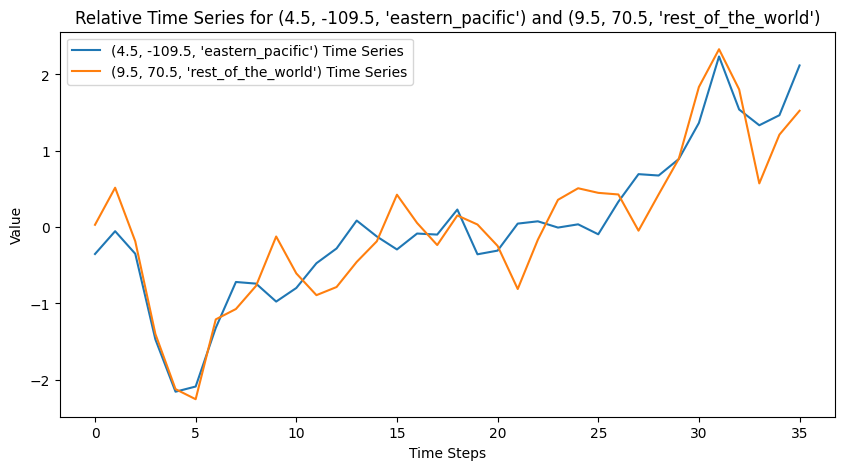

In [107]:
import matplotlib.pyplot as plt

# Iterate through the edges and plot relative time series for each pair
for edge in W.edges(data=True):
    node1, node2, data = edge
    time_series_node1 = W.nodes[node1]['time_series']
    time_series_node2 = W.nodes[node2]['time_series']

    # Plot relative time series
    plt.figure(figsize=(10, 5))
    plt.plot(time_series_node1, label=f'{node1} Time Series')
    plt.plot(time_series_node2, label=f'{node2} Time Series')
    plt.xlabel('Time Steps')
    plt.ylabel('SST')
    plt.title(f'Relative Time Series for {node1} and {node2}')
    plt.legend()
    plt.show()
    break


<font size=80> PLOT

<font size=50> Plot time-series vs nodes

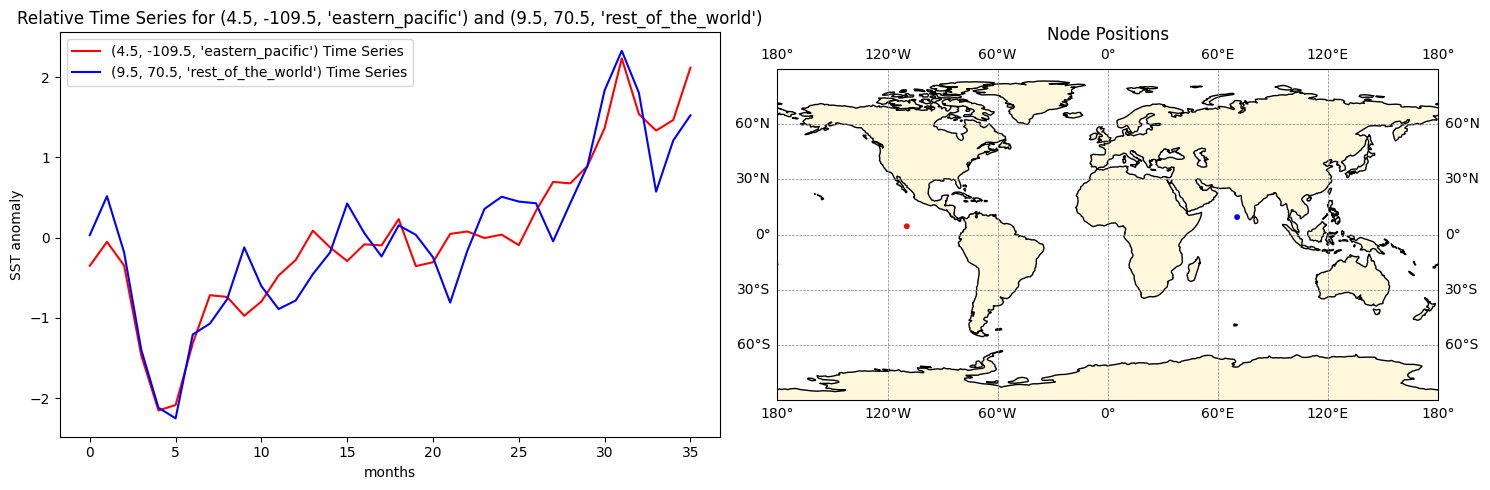

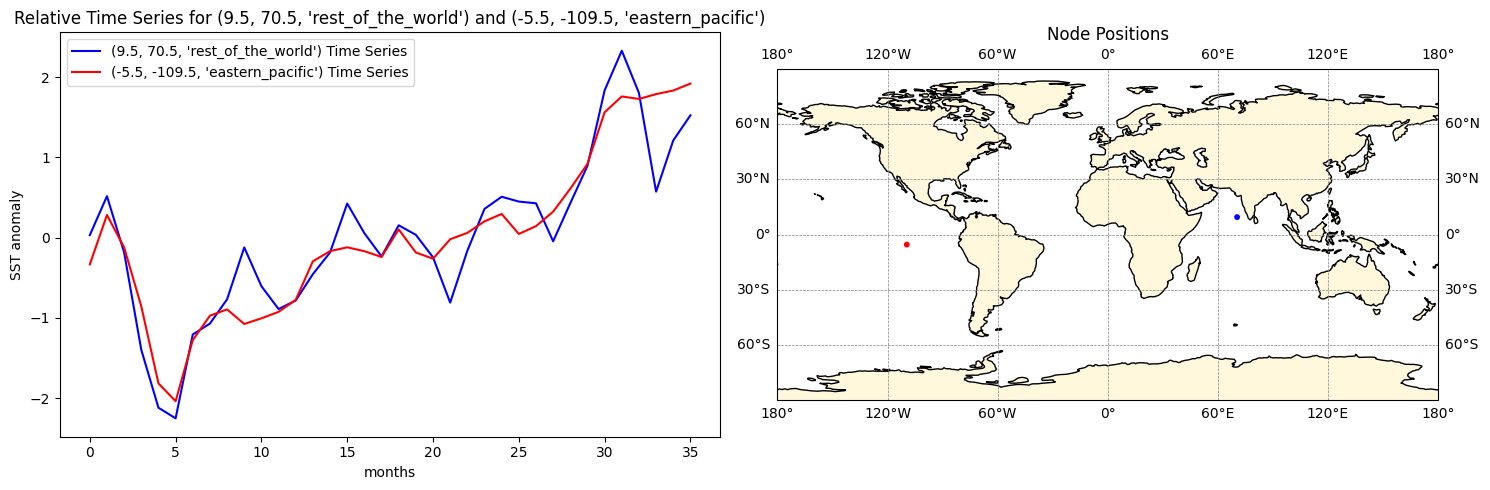

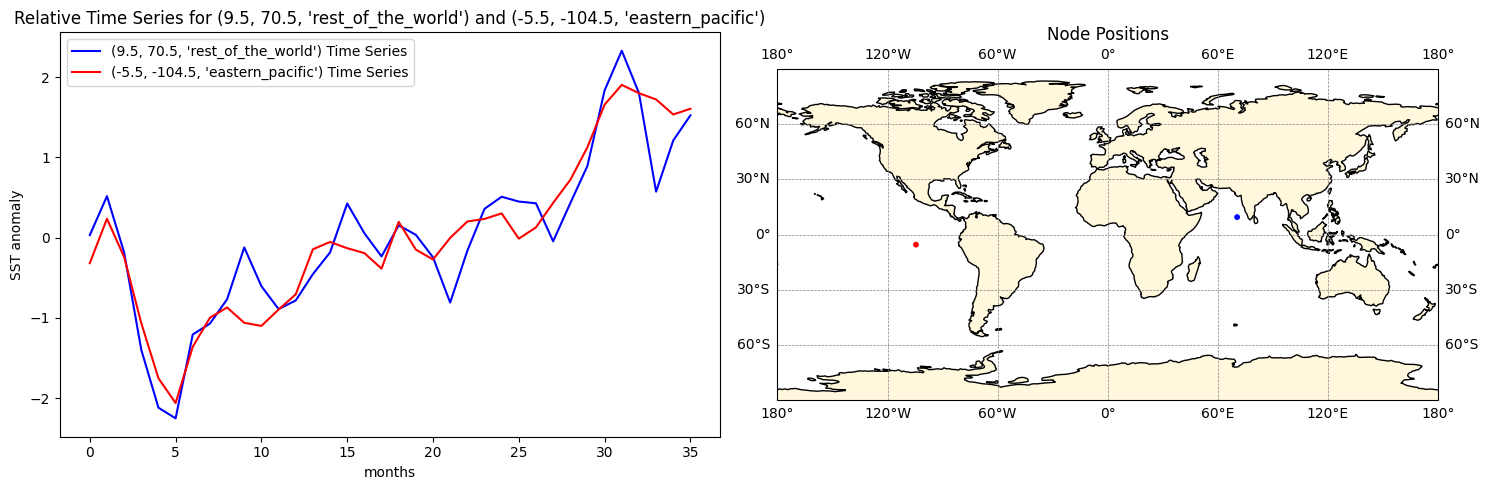

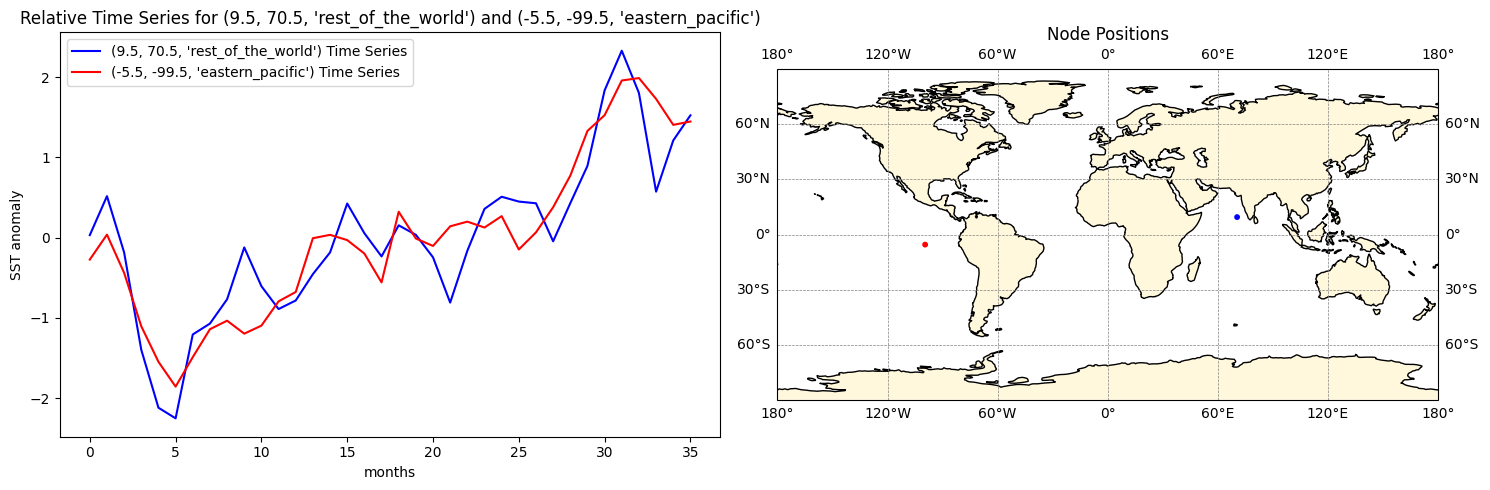

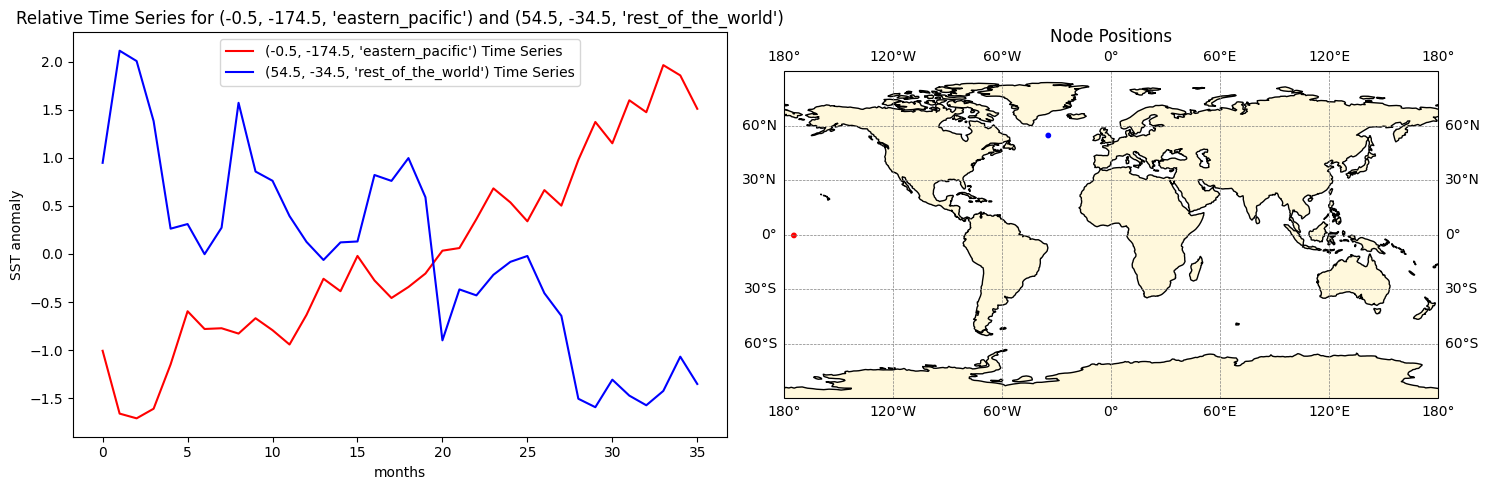

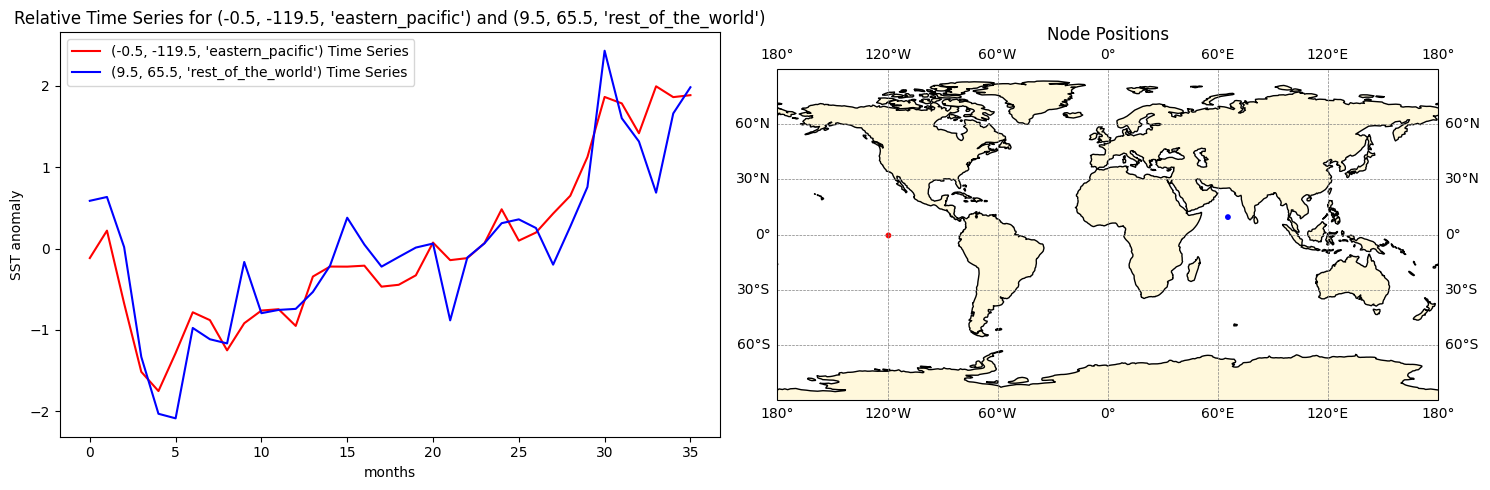

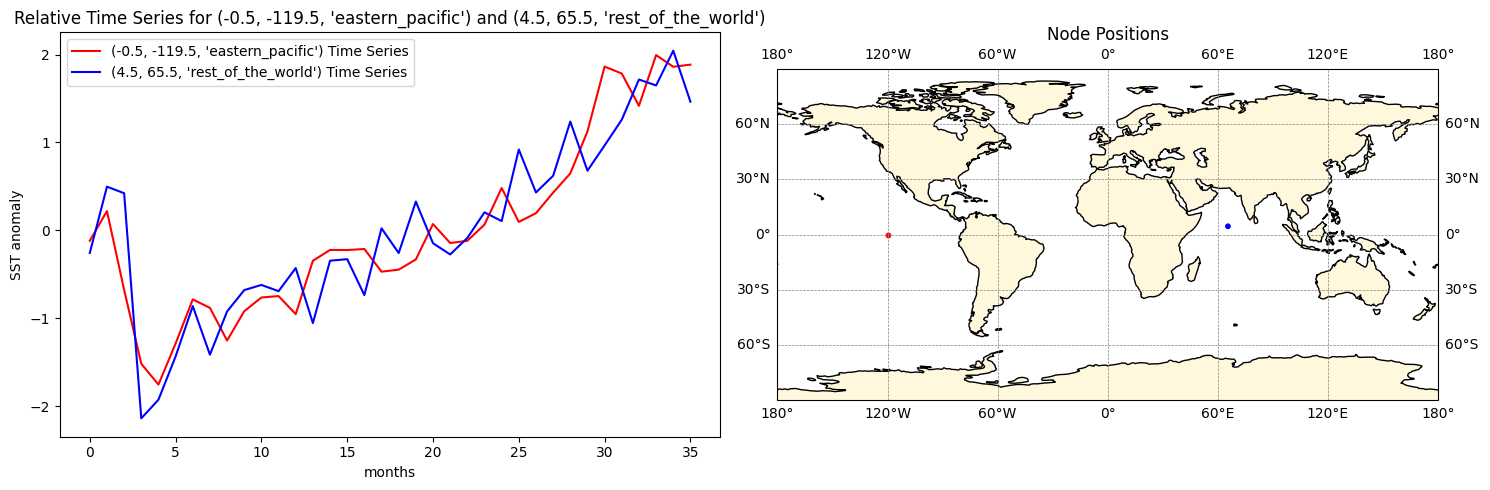

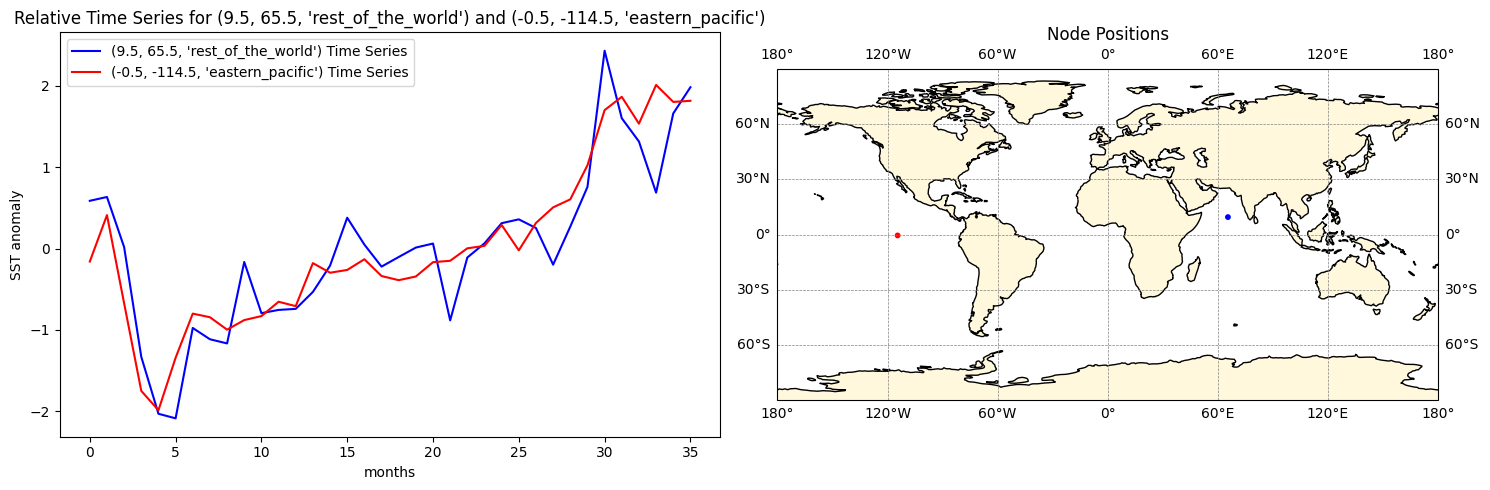

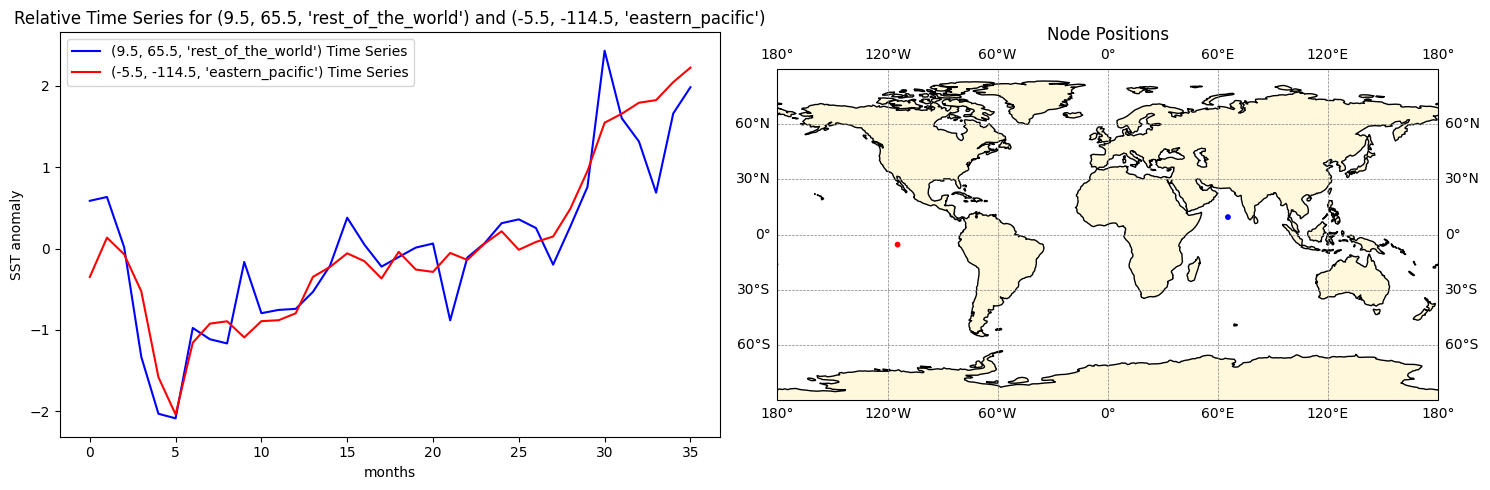

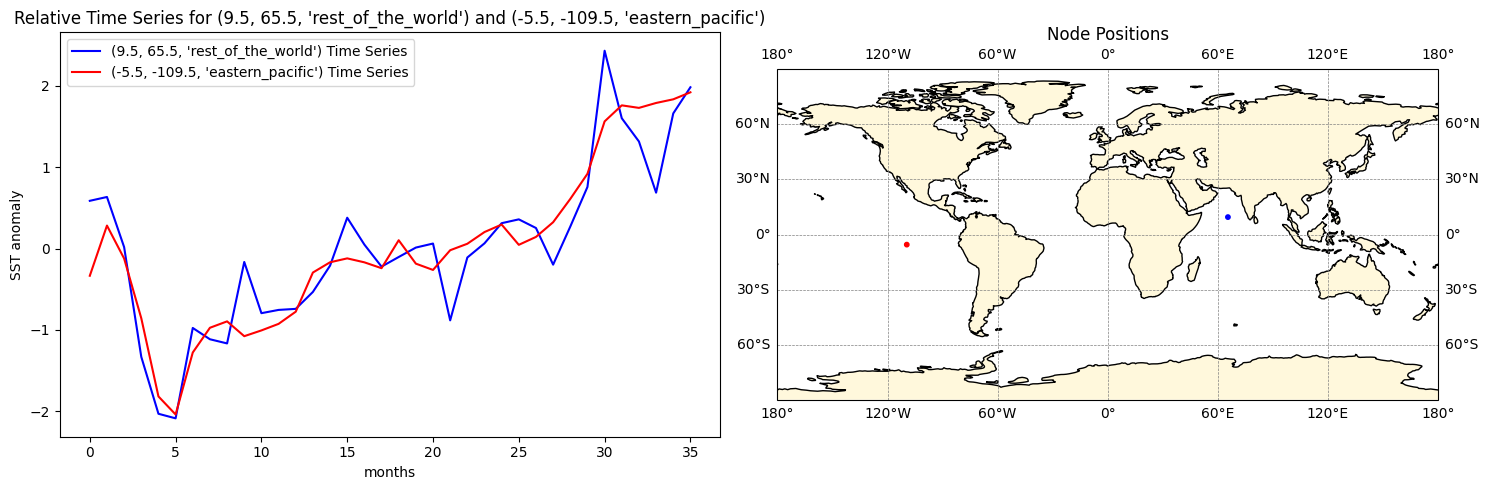

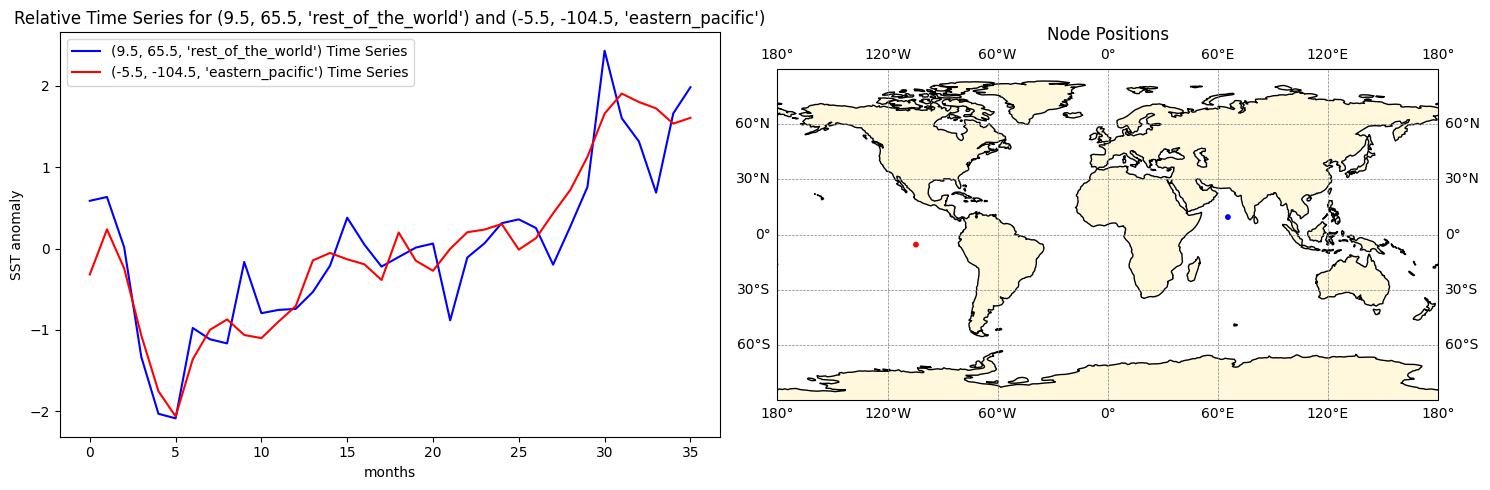

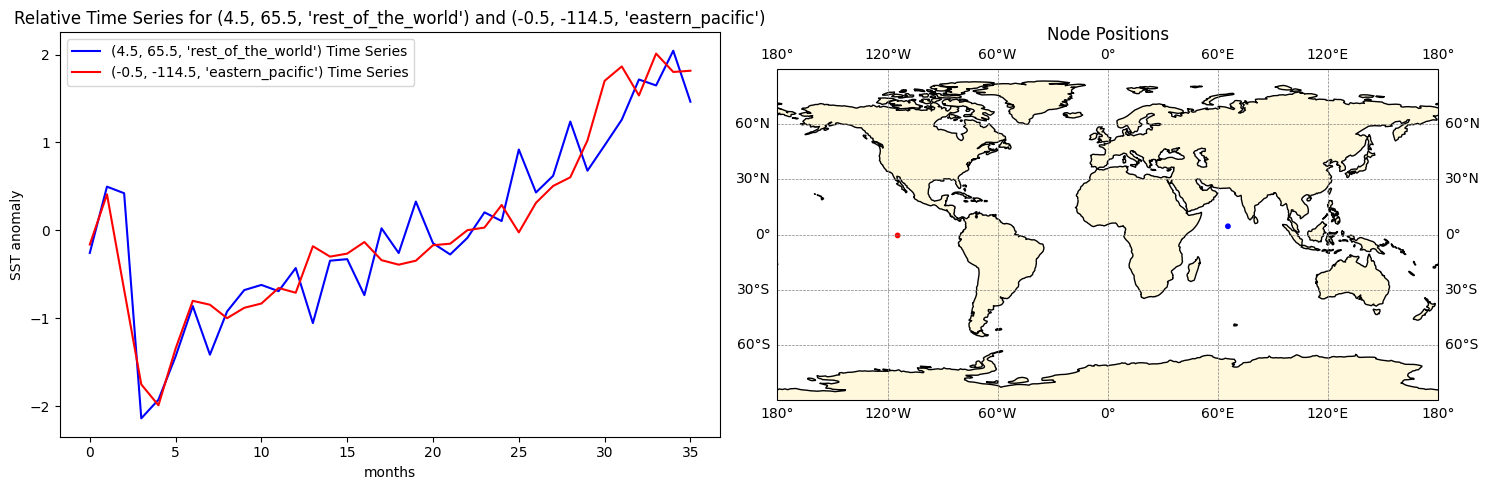

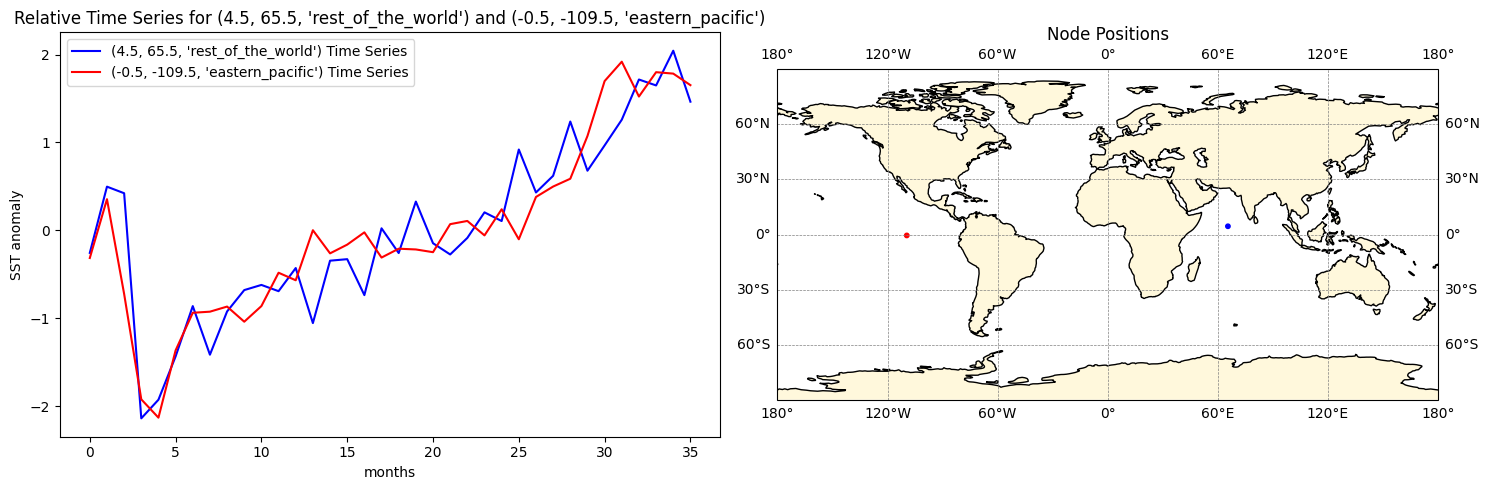

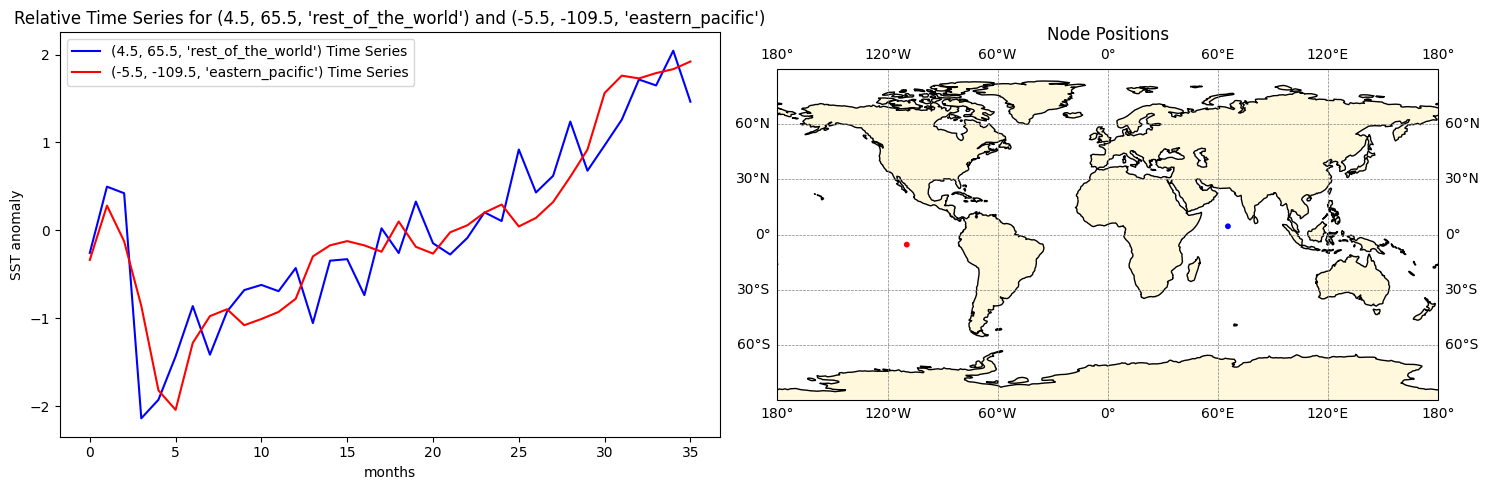

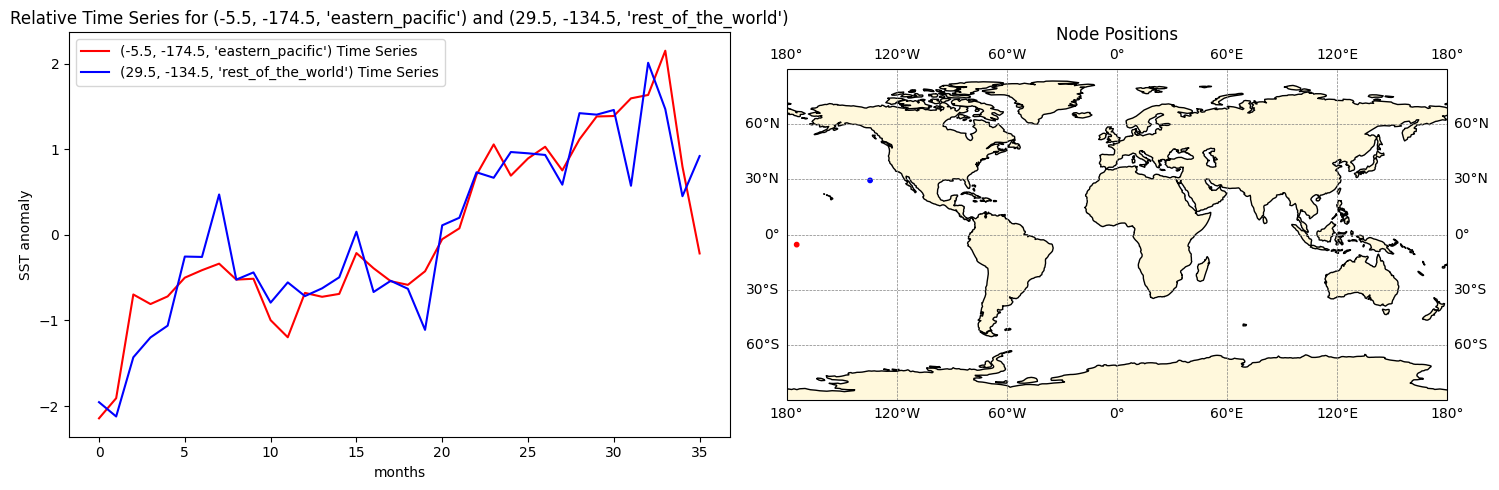

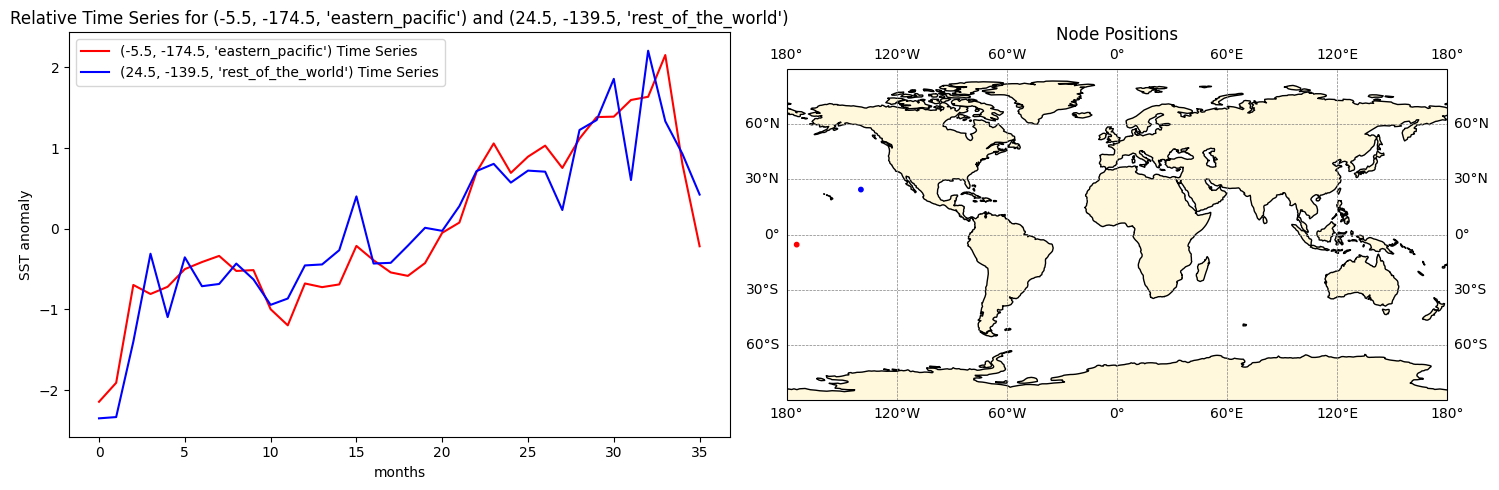

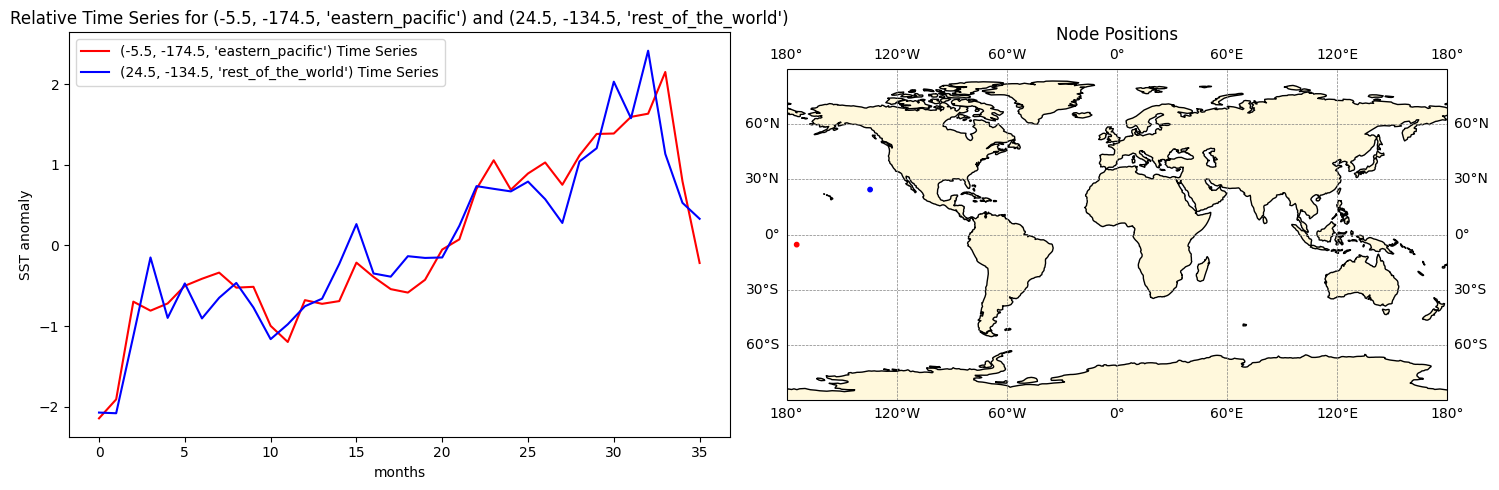

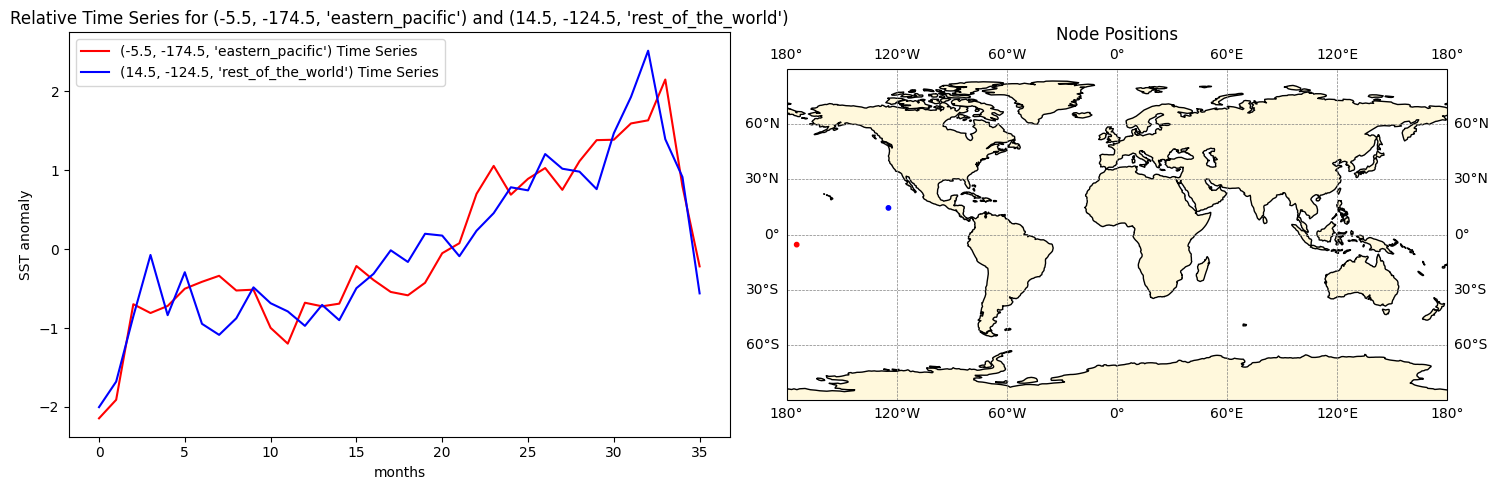

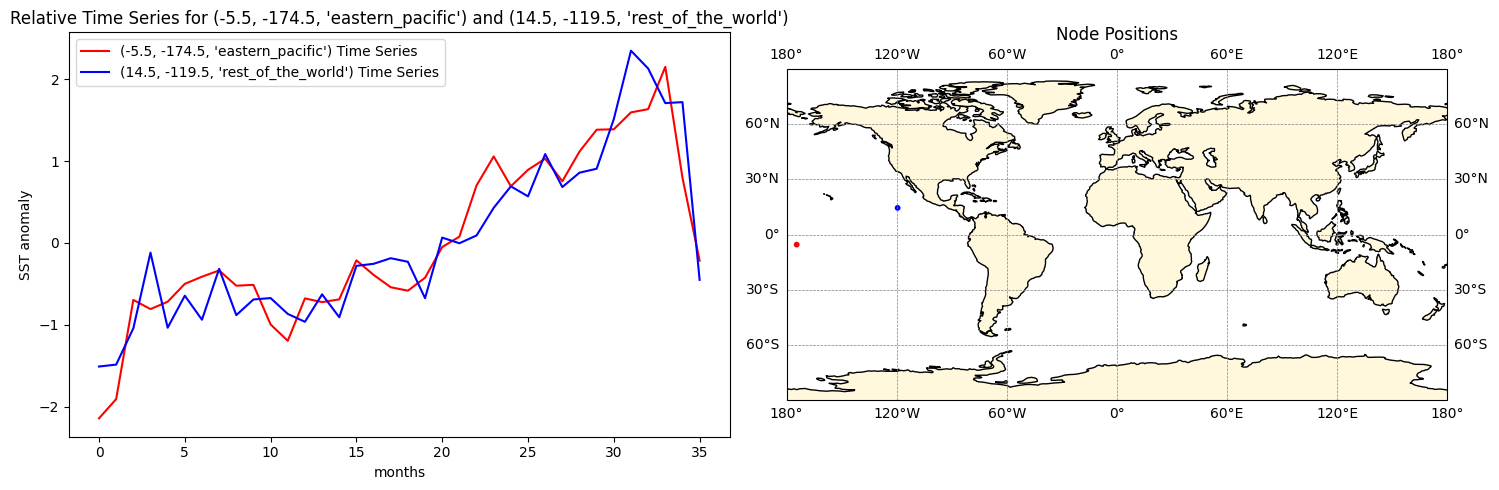

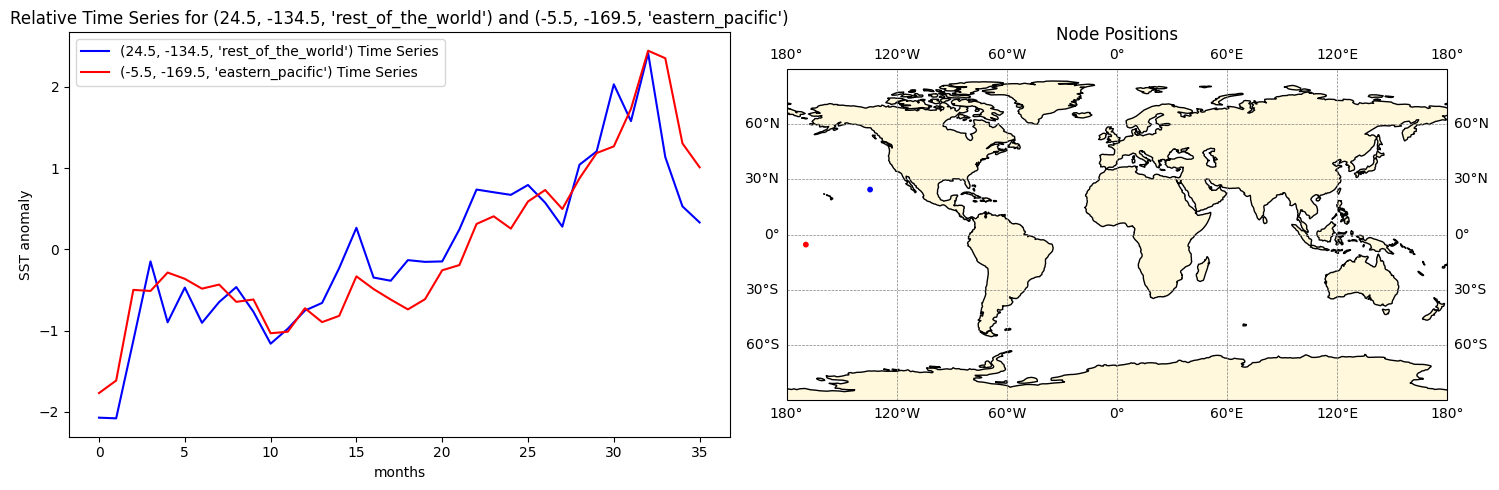

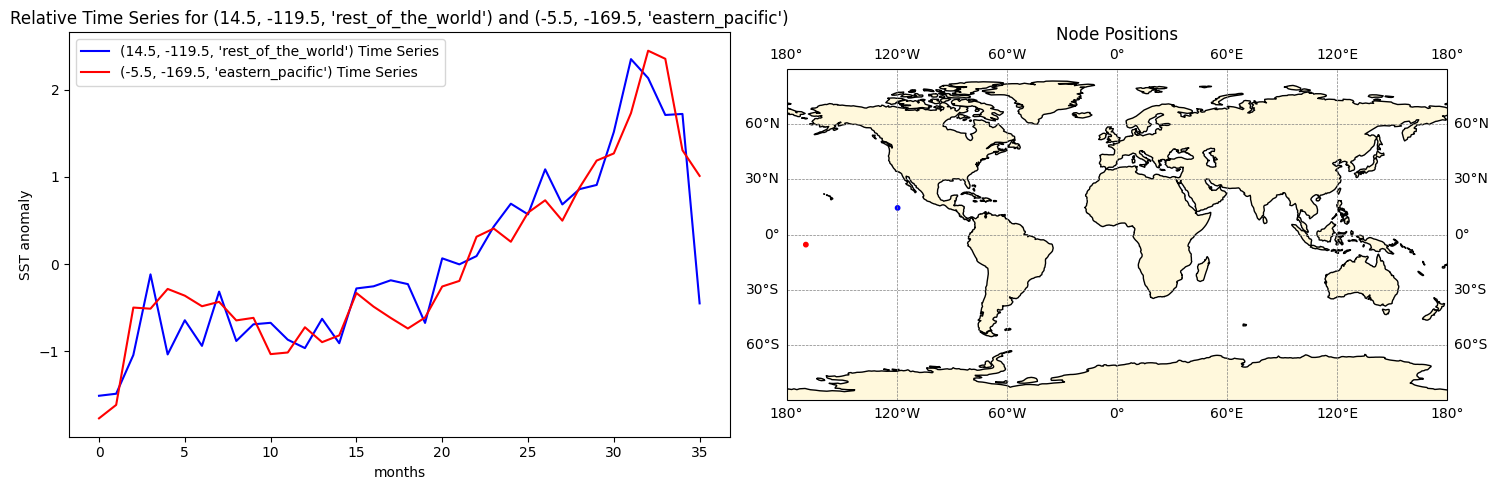

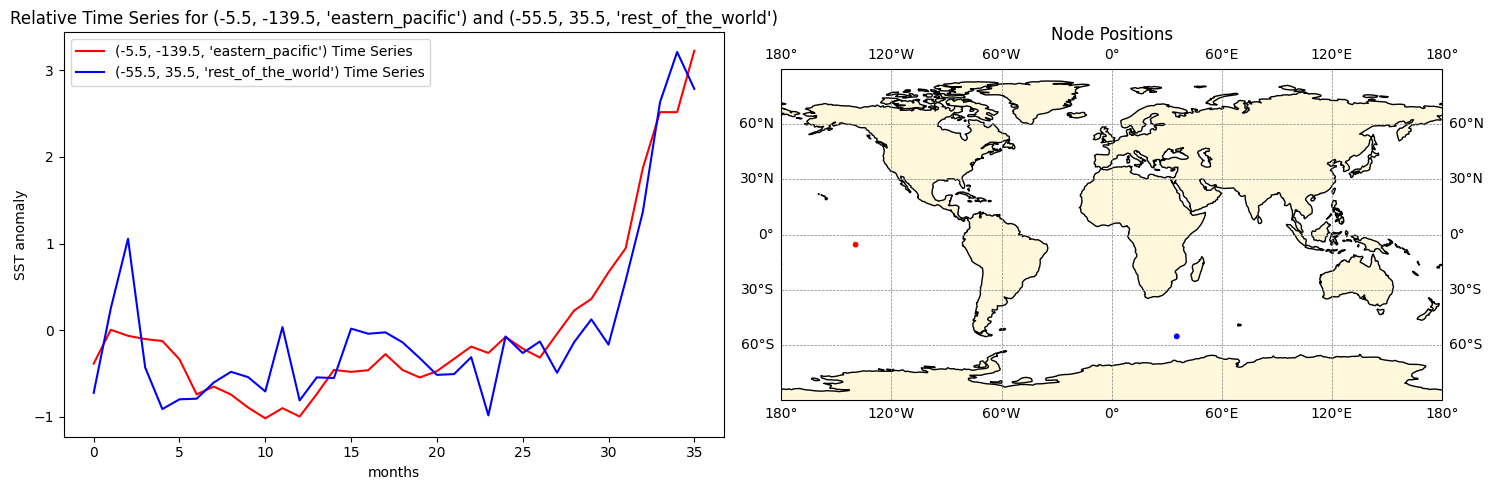

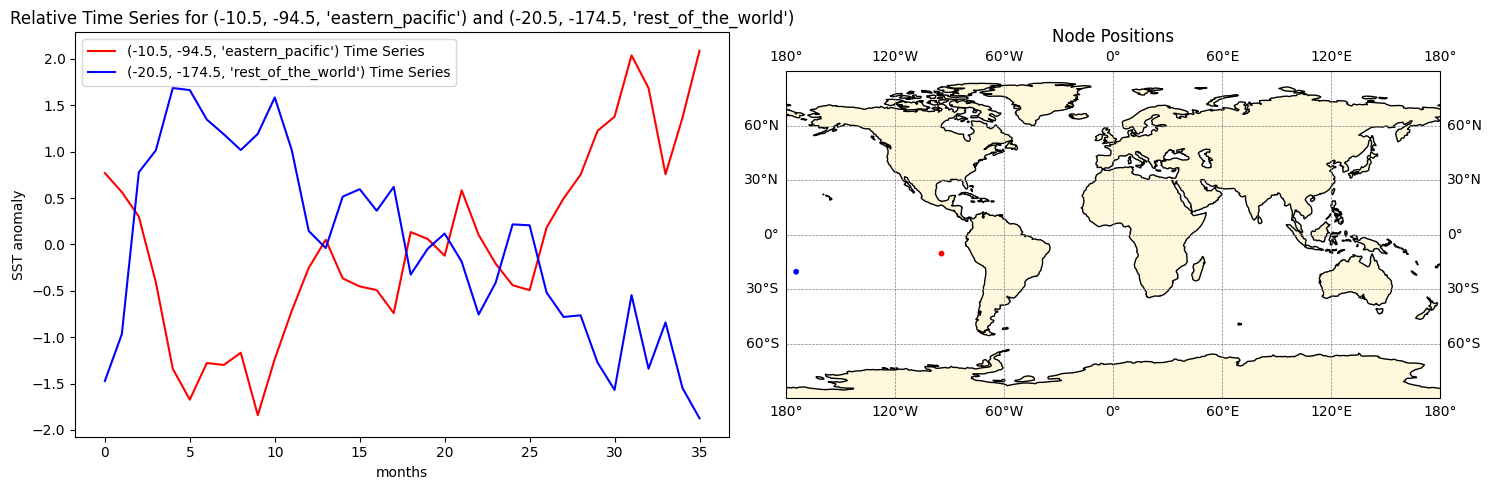

In [16]:
# Iterate through the edges and plot relative time series with Cartopy map
for edge in W.edges(data=True):
    node1, node2, data = edge
    time_series_node1 = W.nodes[node1]['time_series']
    time_series_node2 = W.nodes[node2]['time_series']

    # Extract longitude and latitude from the node attributes
    lon_node1, lat_node1, category_node1 = node1
    lon_node2, lat_node2, category_node2 = node2

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]})

    # Plot time series on the left subplot
    if category_node1 == 'eastern_pacific':
        color_node1 = 'red'
        label_node1 = f'{node1} Time Series'
    else:
        color_node1 = 'blue'
        label_node1 = f'{node1} Time Series'

    if category_node2 == 'eastern_pacific':
        color_node2 = 'red'
        label_node2 = f'{node2} Time Series'
    else:
        color_node2 = 'blue'
        label_node2 = f'{node2} Time Series'

    ax1.plot(time_series_node1, label=label_node1, color=color_node1)
    ax1.plot(time_series_node2, label=label_node2, color=color_node2)
    ax1.set_xlabel('months')
    ax1.set_ylabel('SST anomaly')
    ax1.set_title(f'Relative Time Series for {node1} and {node2}')
    ax1.legend()

    # Plot data on the right subplot using scatterplot reference
    ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
    ax2.coastlines(resolution='110m', color='k')
    ax2.add_feature(cfeature.LAND, facecolor='cornsilk')
    ax2.set_title('Node Positions')

    # Use the scatter method for plotting dots on the map
    ax2.scatter([lat_node1, lat_node2], [lon_node1, lon_node2], c=[color_node1, color_node2], s=10, transform=ccrs.PlateCarree())

    # Customize map appearance
    ax2.set_extent([-180, 180, -90, 90])  # Set the extent to show the entire map
    ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

    # Display the plots
    plt.tight_layout()
    plt.show()
    

<font size=10> Plot connections

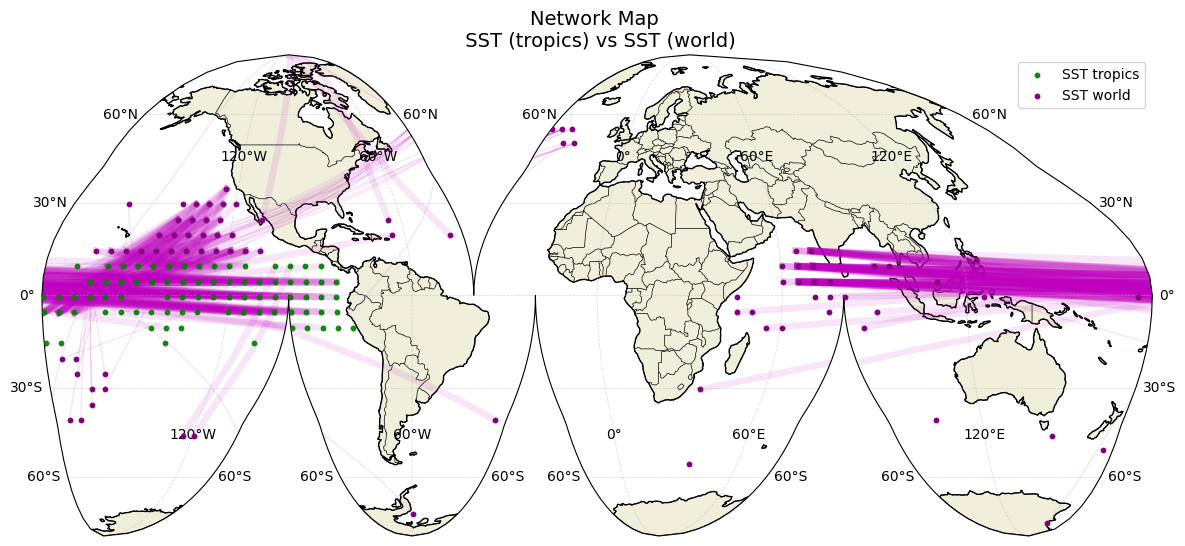

In [25]:
# 

# Generate layout for visualization with Cartopy (changes to long,lat)
pos = {node: (np.mod(node[1], 360), node[0]) for node in W.nodes()} # No need to modify longitudes, assuming they are already in the range -180 to +180

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.InterruptedGoodeHomolosine()})
# ax.set_global()
# ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
#ax.set_extent([-180, 180, -90, 90], crs=ccrs.InterruptedGoodeHomolosine())
# Add world map and gridlines
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(linewidth=0.5, linestyle='dashed', alpha=0.5, draw_labels=True)

# Extract edge weights for edge width
edge_weights = [data['weight'] for _, _, data in W.edges(data=True)]

# Separate nodes based on type
eke_nodes = [node for node in W.nodes() if node[2] == 'eastern_pacific']
frshflux_nodes = [node for node in W.nodes() if node[2] == 'rest_of_the_world']

#PARTE VECCHIA======================================================================
#for edge, weight in zip(G.edges(), edge_weights):
#    normalized_weight = (weight - min(edge_weights)) / (max(edge_weights) - min(edge_weights))  # Normalize weights between 0 and 1
#    edge_width = 1 + 4 * normalized_weight  # Adjust the multiplier for the desired range of edge widths
#    ax.plot([pos[edge[0]][0], pos[edge[1]][0]],
#            [pos[edge[0]][1], pos[edge[1]][1]], 
#            alpha=0.1, color="m", linewidth=edge_width)

# Plot nodes
#ax.scatter([pos[node][0] for node in eke_nodes], [np.mod(pos[node][1],180) for node in eke_nodes], s=10, color="red", alpha=0.9, label='eke',zorder=20001)
#ax.scatter([pos[node][0] for node in frshflux_nodes], [pos[node][1] for node in frshflux_nodes], s=10, color="blue", alpha=1, label='frshflux',zorder=20001)
#======================================================================



#QUI CONTROLLA CHE COSA SUCCEDE ALLE LOGNITUDINI E LATITUDINI============================================
for edge, weight in zip(W.edges(), edge_weights):
    normalized_weight = (weight - min(edge_weights)) / (max(edge_weights) - min(edge_weights))
    edge_width = 1 + 4 * normalized_weight
    #print("prima",pos[edge[0]][1], pos[edge[1]][1])
    lon1 = (np.mod(pos[edge[0]][1], 180))
    lon2 = (pos[edge[1]][1])

    
    ax.plot([pos[edge[0]][0], pos[edge[1]][0]], [lon1, lon2], alpha=0.1, color="m", linewidth=edge_width, transform=ccrs.PlateCarree())

# Plot nodes
ax.scatter([pos[node][0] for node in eke_nodes], [pos[node][1] for node in eke_nodes], 
           s=10, color="green", alpha=0.9, label='SST tropics', zorder=20001, transform=ccrs.PlateCarree())
ax.scatter([pos[node][0] for node in frshflux_nodes], [pos[node][1] for node in frshflux_nodes],
           s=10, color="purple", alpha=1, label='SST world', zorder=20001, transform=ccrs.PlateCarree())
#======================================================================


font = {"fontname": "Helvetica", "color": "k",  "fontsize": 14}
ax.set_title("Network Map \n SST (tropics) vs SST (world)", font)
text1 = AnchoredText("monthly data 2013-2016, res=5deg",
                    loc=3, prop={'size': 8.5}, frameon=True, zorder=24000)



ax.legend()

# Change font color for legend
#font["color"] = "r"


# Resize figure for label readability
ax.margins(0.1, 0.05)
#fig.savefig()
fig.tight_layout()
plt.show()


<font size=8> Interactive plot

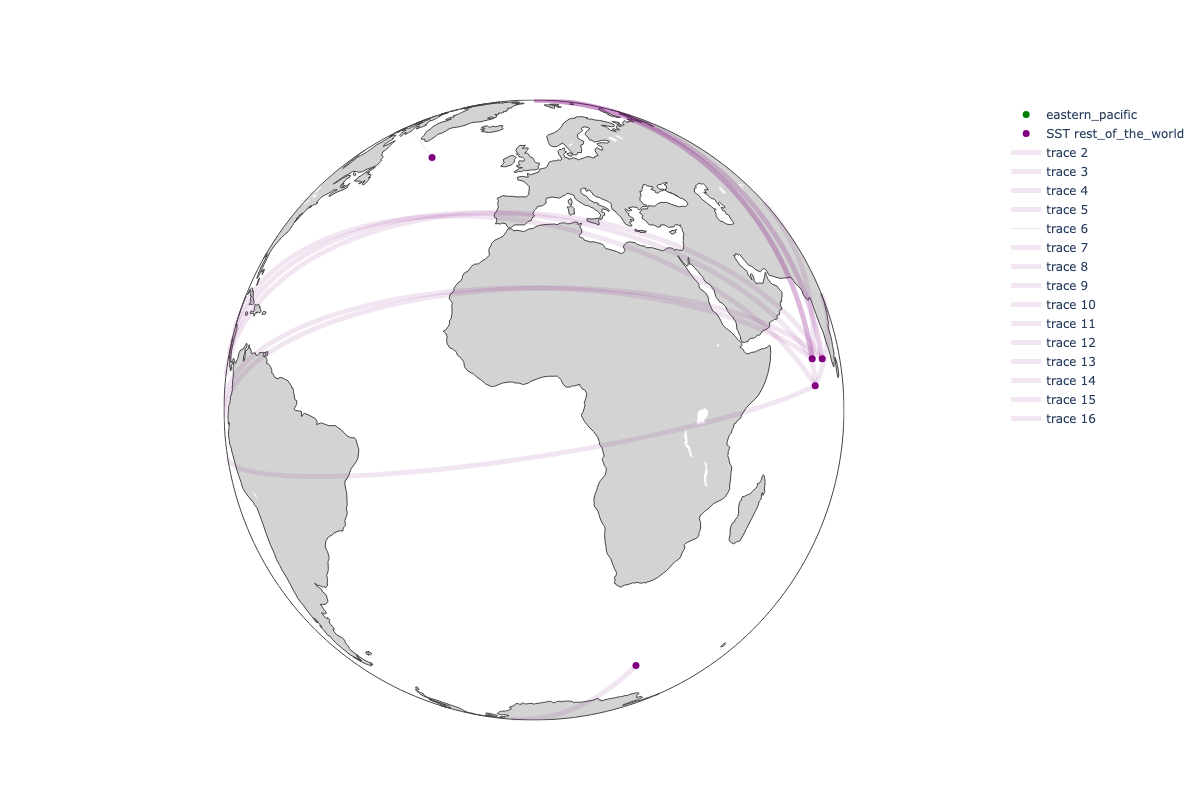

In [62]:
import plotly.graph_objects as go



#pos is reorganising lon and lat because the nodes attributes are (lat,lon) and we want them as (lon,lat)

pos = {node: (np.mod(node[1], 360), node[0]) for node in W.nodes()}  # No need to modify longitudes, assuming they are already in the range -180 to +180

# Extract edge weights for edge width
edge_weights = [data['weight'] for _, _, data in W.edges(data=True)]

# Separate nodes based on type
eke_nodes = [node for node in W.nodes() if node[2] == 'eastern_pacific']
frshflux_nodes = [node for node in W.nodes() if node[2] == 'rest_of_the_world']

# Create a Plotly graph object
fig = go.Figure()

# Plot 'eke' nodes
fig.add_trace(go.Scattergeo(
    lon=[pos[node][0] for node in eke_nodes],
    lat=[pos[node][1] for node in eke_nodes],
    mode='markers',
    marker=dict(
        size=7,
        color="green",
    ),
    name='eastern_pacific',
))

# Plot 'frshflux' nodes
fig.add_trace(go.Scattergeo(
    lon=[pos[node][0] for node in frshflux_nodes],
    lat=[pos[node][1] for node in frshflux_nodes],
    mode='markers',
    marker=dict(
        size=7,
        color="purple",
    ),
    name='SST rest_of_the_world',
))

# Plot edges
for edge, weight in zip(W.edges(), edge_weights):
    normalized_weight = (weight - min(edge_weights)) / (max(edge_weights) - min(edge_weights))
    edge_width = 1 + 4 * normalized_weight
    fig.add_trace(go.Scattergeo(
        lon=[pos[edge[0]][0], pos[edge[1]][0], None],  # None to create a gap between segments
        lat=[pos[edge[0]][1], pos[edge[1]][1], None],
        mode='lines',
        line=dict(
            width=edge_width,
            color='rgba(128, 0, 128, 0.1)',
        ),
        text=f'Correlation: {weight}',
        hoverinfo='text',
    ))

# Update layout for better visibility
fig.update_layout(
    geo=dict(
        showland=True,
        landcolor="#D3D3D3",  # Set the color for the land
        projection_type="orthographic"
    ),
    width=1000,  # Set the width of the plot
    height=800   # Set the height of the plot
)

# Set legend entries
fig.update_layout(
    legend=dict(
        traceorder='normal',
    ),
)

# Save the plot as an HTML file
#fig.write_html("SSTtropSSTwrld_2013_16_step20.html")

# Show the plot
fig.show()


<font size=10>node degree map

In [65]:
nx.density(W)

0.14285714285714285

In [64]:


# Generate layout for visualization with Cartopy
pos = {node: (node[1], node[0]) for node in W.nodes()}  # Convert longitudes to the range -180 to +180

# Calculate node degrees
degrees = dict(W.degree())

# Extract node positions, sizes, and colors based on node type
node_positions = np.array([pos[node] for node in W.nodes()])
node_sizes = np.array([degrees[node] for node in W.nodes()])
node_colors = ['green' if node[2] == 'eastern_pacific' else 'purple' for node in W.nodes()]

# Create a scatter plot with node sizes proportional to degree and colors based on type
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')

# Scatter plot nodes with a small black dot at the center
sc = ax.scatter(
    node_positions[:, 0], node_positions[:, 1], s=node_sizes * 30,
    c=node_colors, alpha=0.6, edgecolors='k', linewidths=0.5
)

# Add a black dot at the center of each circle representing a node
#ax.scatter(node_positions[:, 0], node_positions[:, 1], color='black', s=2)

# Set the geographical extent to cover the entire world
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add world map and gridlines
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(linewidth=0.5, linestyle='dashed', alpha=0, draw_labels=True)

# Title
font = {"fontname": "Helvetica", "color": "k",  "fontsize": 14}
ax.set_title("Node Degree Map \n SST (tropics) vs PREC (world) in Jan 2013 - Oct 2013", font)
text1 = AnchoredText("weekly data 2013-2013, res=5deg",
                    loc=3, prop={'size': 8.5}, frameon=True, zorder=24000)
ax.add_artist(text1)


# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
#fig.savefig("SSTtropSSTwrld_2013_13_step20.png")
plt.show()


AttributeError: 'Graph' object has no attribute 'density'

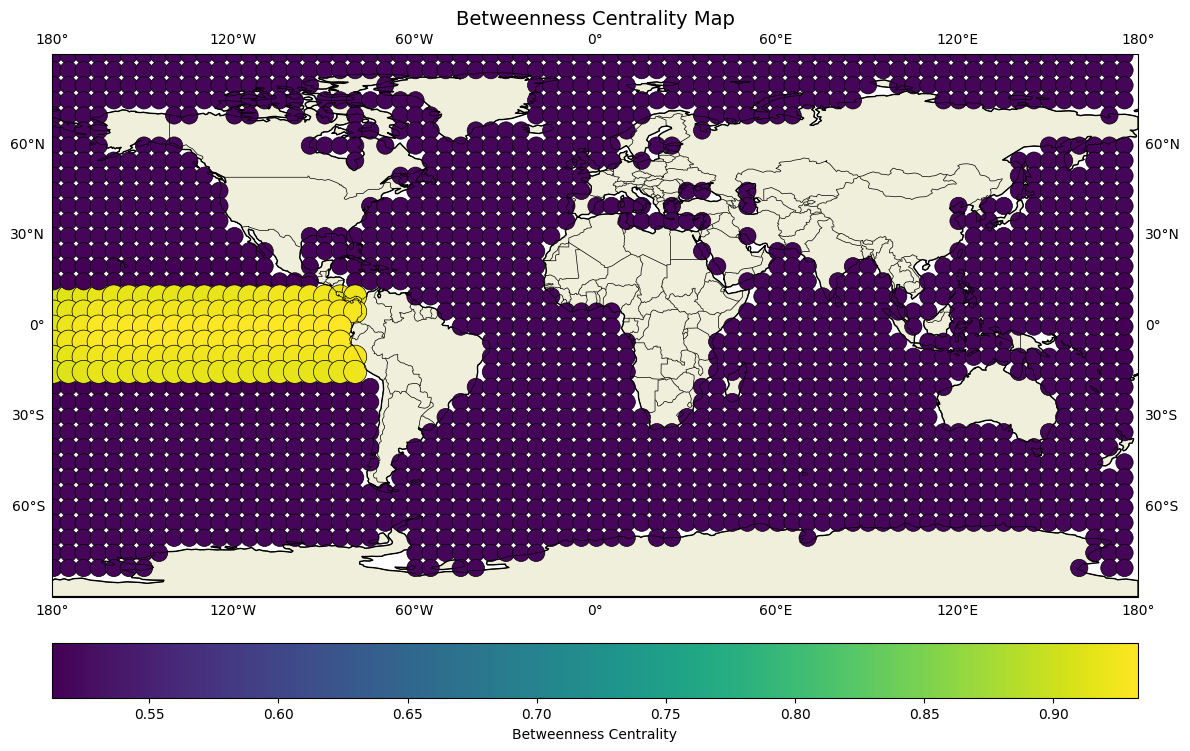

In [52]:



# Calculate betweenness centrality for each node
betweenness_centrality = nx.closeness_centrality(W)

# Generate layout for visualization with Cartopy
pos = {node: (node[1], node[0]) for node in W.nodes()}  # Convert longitudes to the range -180 to +180

# Extract node positions, sizes, and colors based on betweenness centrality
node_positions = np.array([pos[node] for node in W.nodes()])
node_sizes = np.array([betweenness_centrality[node] for node in W.nodes()])
node_colors = np.array([betweenness_centrality[node] for node in W.nodes()])

# Create a scatter plot with node sizes proportional to betweenness centrality
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')

# Scatter plot nodes with a small black dot at the center
sc = ax.scatter(
    node_positions[:, 0], node_positions[:, 1], s=node_sizes * 300,
    c=node_colors, cmap='viridis', edgecolors='k', linewidths=0.5
)


# Set the geographical extent to cover the entire world
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add world map and gridlines
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(linewidth=0.5, linestyle='dashed', alpha=0, draw_labels=True)

# Add colorbar
cbar = plt.colorbar(sc, orientation='horizontal', pad=0.04)
cbar.set_label('Betweenness Centrality')

# Title
font = {"fontname": "Helvetica", "color": "k", "fontsize": 14}
ax.set_title("Betweenness Centrality Map", font)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.show()

